# Seasonal cycle of MMLI

In [1]:
import sys
sys.path.insert(0, "/users/jwindmil/2019_WMI/util")

# Initial imports
import Landau_Potential_Diffusion as Landau
import curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import argrelextrema
import random
import pandas as pd

import pickle

In [2]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

In [3]:
def cm_to_inch(m_cm):
    return m_cm/2.54

In [4]:
path = '/project/s916/ERA5_Tom/'
path_PKL = '/users/jwindmil/2019_WMI/dev/jwindmiller/PKL_DATA/'

### Choose stripe like domain in the Atlantic ocean

Choose domain such that no land is included in domain (excepting Cape Verde Islands)

In [5]:
latmin = -23
latmax = 23
lonmin = 360-34
lonmax = 360-18

Select period (exclude 2018 as it is only partly available)

In [6]:
date1, date2 = np.datetime64('2000-01-01T00:00'), np.datetime64('2017-12-31T23:00')

Use 83rd percentile which gives the location of the antimode in the bimodal distribution for the respective domain. 

Note: Jakob et al. (2019) suggest a ratio of about 7.7 for deep organized convection/suppressed cloud regime (Fig. 11, blue number for largest). This would correspond to a subsiding regime covering about 88.5 percent of the tropics. Comparable values but 83rd percentile is domain dependent. 

In [7]:
thresh = 83 #48

In [8]:
PW = xr.open_mfdataset(path+'????/??PW.nc',combine='by_coords')
PWAtl = PW['tcwv'].sel({'time':slice(date1, date2), 'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = PW.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = PW.latitude.sel({'latitude':slice(latmax,latmin)})

In [9]:
time_A = PWAtl.time.values

In [28]:
# Calculate Area of domain assuming a rectangle (since we assumed constant dx for the contour)
dx = 110/4 #km
A_domain = lonAtl*latAtl*(dx**2) #km**2
L_band = 2.0*lonAtl*dx
circle_sw = False

In [11]:
year = 2009
YEAR = np.arange(2000,2018)# np.append(np.arange(2000,2014), np.arange(2015,2018)) #2014 is missing!

### Load contour length and area

In [12]:
path_PKL+'CONTOURL_PW_%i_%i_%i_%i_%i_'%(latmin, latmax, lonmin, lonmax, thresh)+str(year)+'.pkl'

'/users/jwindmil/2019_WMI/dev/jwindmiller/PKL_DATA/CONTOURL_PW_-23_23_326_342_83_2009.pkl'

In [13]:
# Calculate MMLI from CON_data assuming band or circle shape

MMLI_PW_data = {}
CONT_PW_data = {}
AREA_PW = {}

for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open(path_PKL+'CONTOURL_PW_%i_%i_%i_%i_%i_'%(latmin, latmax, lonmin, lonmax, thresh)+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    AREA_PW[str(year)] = tmp["Tot_Area_km2"]
    MMLI_PW_data[str(year)] = 2.0*np.sqrt(np.pi*tmp["Tot_Area_km2"])/tmp['Tot_Contour_km'][str(year)] if circle_sw else L_band/tmp['Tot_Contour_km'][str(year)] #L_band/tmp['Tot_Contour_km'][str(year)]
    CONT_PW_data[str(year)] = tmp['Tot_Contour_km'][str(year)]
    

In [14]:
data_t = np.array(get_all_values(MMLI_PW_data))
cont_t = np.array(get_all_values(CONT_PW_data))

#data_t[cont_t==0] = np.nan
len(cont_t), len(data_t)

(157800, 157800)

In [15]:
area_t = np.array(get_all_values(AREA_PW))

### Calculate seasonal cycle of MMLI

In [16]:
time_eval = [np.datetime64('2000-%02i-01T00:00'%i) for i in np.repeat(range(1,13),2)]+[np.datetime64('2000-12-31T23:00')]
time_eval[1::2] = time_eval[1::2]+np.timedelta64(15,'D')+np.timedelta64(23,'h')
time_eval_doy = pd.DatetimeIndex(time_eval).dayofyear

/users/jwindmil/venv-3.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


[numpy.datetime64('2000-01-16T23:00'), numpy.datetime64('2000-03-16T23:00'), numpy.datetime64('2000-07-01T00:00'), numpy.datetime64('2000-09-16T23:00'), numpy.datetime64('2000-10-16T23:00')]
[ 1  5 12 17 19]


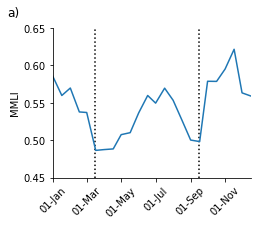

In [17]:
def plot_seasonal_cycle(ax_sc = None):
    if ax_sc == None:
        fig_sc, ax_sc = plt.subplots(1,1,figsize=(cm_to_inch(9), cm_to_inch(7)))

    data_day = pd.DatetimeIndex(time_A).dayofyear
    days = time_eval_doy

    data_w = np.ones(len(days)).astype(float)

    for i, day in enumerate(days[:-1]):
        data_w[i] = np.nanmean(data_t[np.where((data_day>=day)&(data_day<days[i+1]))])

    ax_sc.plot(time_eval[:-1], data_w[:-1]) #gaussian_filter1d(data_w, sigma=2), 'C1')
    
    print([time_eval[:-1][i] for i in argrelextrema(np.array(data_w[:-1]), np.less)[0]])
    print(argrelextrema(np.array(data_w[:-1]), np.less)[0])

    ymin, ymax = ax_sc.set_ylim(ymin=0.45, ymax=0.65)

    ax_sc.vlines([np.datetime64('2000-03-16'), np.datetime64('2000-09-16')], ymin, ymax, linestyle=':')

    ax_sc.set_ylim(ymin, ymax)


    #plt.xlabel('day')
    ax_sc.set_ylabel('MMLI')
    
    text = ax_sc.text(-0.2, 1.1,'a)', fontsize = 12, horizontalalignment='center', verticalalignment='center', transform = ax_sc.transAxes)

    locs, labels = plt.xticks()

    _=plt.xticks(locs, labels, rotation=45) 

    # every_nth = 2
    # for n, label in enumerate(ax.xaxis.get_ticklabels()[::1]):
    #     if n % every_nth != 0:
    #         print(n)
    #         label.set_visible(False)

    ax_sc.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
    ax_sc.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%b"))



    ax_sc.set_xlim(np.datetime64('2000-01-01'), np.datetime64('2000-12-16'))

    ax_sc.spines['right'].set_visible(False)
    ax_sc.spines['top'].set_visible(False)
    
plot_seasonal_cycle()

plt.savefig('Figures/seasonal_cycle.pdf', bbox_inches='tight')

During boreal spring (MAM) the ITCZ reaches is southermost extent. During this time, the impact of land on the part of the ITCZ investigated in our domain is expected to be largest. Considering e.g. Fig. 1 of citet{Chiang2002} shows that the ITCZ is widest during boreal spring and its shape is clearly impacted by South America. Note that citet{Chiang2002} also note that this is the season of the year in which the ITCZ location and the precipitation magnitude are most variable. 
One possible explanation of the local minimum of MMLI during boreal spring (vertical line indicates the 15th of April) is that the impact of land distorts the humidity field. 

A second minimum in MMLI is found during boreal autumn. Visual inspection suggests that this minimum in MMLI is caused by the presence of hurricanes (vertical line indicates peak of hurricane season in the tropical Atlantic, see https://www.nhc.noaa.gov/climo/). 

### Show example plots

In [20]:
dic_Fig5 = {}

In [25]:
dic_Fig5['lonAtl'], dic_Fig5['latAtl'], dic_Fig5['time_A'] = lonAtl, latAtl, time_A

In [21]:
dic_Fig5['time_snapshots'] = [np.datetime64('2010-05-01T18:00'), np.datetime64('2010-06-20T12:00'), np.datetime64('2010-09-09T12:00')]

In [23]:
for i, time in enumerate(dic_Fig5['time_snapshots']):
    tmp = np.squeeze(PWAtl.sel({'time':time}).values)
    dic_Fig5[time]=tmp

['30S', '20S', '10S', 'EQ', '10N', '20N', '30N']
Year 2010


<Figure size 432x288 with 0 Axes>

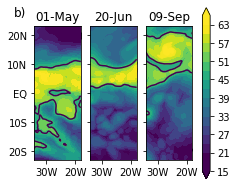

<Figure size 432x288 with 0 Axes>

In [24]:
def plot_seasonal_cycle_exp(axes = [None]):
    
    times_snapshots = dic_Fig5['time_snapshots']

    num_sp = len(times_snapshots)

    if axes[0] == None:
        fig, axes = plt.subplots(1, num_sp, figsize=(cm_to_inch(9), cm_to_inch(8)), sharey = True)
        
    print(axes)
    
   # axes[0].set_title('a)', position = (0.,0.))
    
    for i, time in enumerate(times_snapshots):

        tmp = dic_Fig5[time]

        axes[i].contour(lonAtl, latAtl, tmp, [48.00])#, vmin = 2.7e9, vmax=2.85e9)
        im = axes[i].contourf(lonAtl, latAtl, tmp, 20, vmin = 20, vmax = 62, extend='both')
        for c in im.collections:
            c.set_edgecolor("face")
        axes[i].set_aspect('equal')

        locs = axes[i].get_xticks()
        labels = list(np.arange(len(locs)))
        for i_l, loc in enumerate(locs):
            labels[i_l] = '%iW'%int(360-loc)
        axes[i].set_xticklabels(labels) 

        axes[i].set_title(pd.to_datetime(time).strftime("%d-%b"), loc ='center')
    
    text = axes[0].text(-0.3, 1.1,'b)', fontsize = 12, horizontalalignment='center', verticalalignment='center', transform = axes[0].transAxes)

    locs = axes[0].get_yticks()
    labels = list(np.arange(len(locs)))
    for i_l, loc in enumerate(locs):
        if loc >0:
            labels[i_l] = '%iN'%int(loc)
        elif loc == 0:
            labels[i_l] = 'EQ'
        else:
            labels[i_l] = '%iS'%int(loc*-1)
            
    #axes[i].set_yticks(locs)     
    axes[0].set_yticklabels(labels)
    print(labels)

    cbar = plt.colorbar(im, ax=axes.ravel().tolist())

    print(pd.to_datetime(time).strftime("Year %Y"))

#plt.tight_layout()
plot_seasonal_cycle_exp()

plt.savefig('Figures/seasonal_cycle_snapshots.pdf', bbox_inches='tight')

plt.figure()

In [29]:
with open('dic_Fig5.pickle', 'wb') as handle:
    pickle.dump(dic_Fig5, handle, protocol=pickle.HIGHEST_PROTOCOL)

